In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess

from os.path import exists

import read_config_utils as cu

import matplotlib as mpl

In [2]:
#input_dir = 'output-files-bootstrap-test7-2d'

#input_dir = 'output-files-bootstrap-test6b-2d-2a-100k'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-v1b'

#input_dir = 'output-files-bootstrap-test6b-2d-2a'




#input_dir = 'bootstrap-toy-study6b-2d-4c'

#input_dir = 'bootstrap-simple-pdf-toy-study6b-2d-4c'



#input_dir = 'freshtoys-simple-pdf-toy-study6b-2d-4c'

#input_dir = 'freshtoys-toy-study6b-2d-4c'



#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model'

#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model/freshmc-01'
#input_dir = 'freshtoys-toy-study6b-2d-4c-save-model/freshmc-02'




#input_dir = 'bootstrap-toy-study6b-1d-1a'
#input_dir = 'bootstrap-toy-study6b-1d-1a-badres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-goodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-verygoodres'
#input_dir = 'bootstrap-toy-study6b-1d-1a-perfect'

#input_dir = 'bootstrap-toy-study6b-1d-1a-nb1000'


#input_dir = 'simple-pdf-toy-study6b-1d-1a-1k'



#input_dir = 'fit-pdf-toy-study-2d-1a'

#input_dir = 'fit-pdf-toy-study-1d-1a'

#input_dir = 'hist-pdf-toy-study-1d-1b'

#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution-5k-toys'


#input_dir = 'bootstrap-toy-study8a-1d-1c'

#input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
#input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1a-badres'



#input_dir = 'bootstrap-toy-study8a-1d-1d'

#input_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'

#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'

#-----



#input_dir = 'hist-pdf-toy-study-1d-1a-perfect'
#input_dir = 'hist-pdf-toy-study-1d-1a-goodres'
#input_dir = 'hist-pdf-toy-study-1d-1a-nominal-resolution'
#input_dir = 'hist-pdf-toy-study-1d-1b-mediumbad'


#input_dir = 'bootstrap-toy-study8a-1d-1d-perfect'
#input_dir = 'bootstrap-toy-study8a-1d-1d'
#input_dir = 'bootstrap-toy-study8a-1d-1d-nominal-resolution'
#input_dir = 'bootstrap-toy-study8a-1d-1d-gpu0'



input_dir = 'hist-pdf-toy-study-1d-2a'

input_dir = 'bootstrap-toy-study8a-1d-2a'




with open( '%s/train-and-true-samples.npy' % input_dir, 'rb') as f :
    train_pts = np.load(f)
    train_det_pts = np.load(f)
    true_pts = np.load(f)
    true_det_pts = np.load(f)
    
print('\n\n')
print(' shape of train_pts:  %s' % str(train_pts.shape))
print(' shape of true_pts:   %s' % str(true_pts.shape))
print('\n\n')






 shape of train_pts:  (1000000, 1)
 shape of true_pts:   (100000, 1)





In [3]:
config_file = '%s/config.txt' % (input_dir)

if not exists(config_file) :
    
    print("\n\n\n ******* Input file does not exist: %s\n\n\n" % config_file )
    sys.exit()
    

In [4]:
ndim = int(cu.get_par( config_file, "ndim"))
print("\n\n Number of feature dimensions: %d\n\n" % ndim)



 Number of feature dimensions: 1




In [5]:
with open( '%s/config-pars.npy' % input_dir, 'rb') as f :
    train_mu = np.load(f, allow_pickle=True )
    train_rho = np.load(f, allow_pickle=True)
    train_sig = np.load(f, allow_pickle=True)    
    true_mu = np.load(f, allow_pickle=True )
    true_rho = np.load(f, allow_pickle=True)
    true_sig = np.load(f, allow_pickle=True)  
    resolution = np.load(f, allow_pickle=True)

<function matplotlib.pyplot.show(close=None, block=None)>

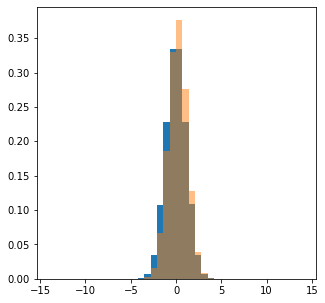

In [6]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))



hmin=-5
hmax=5


hmin=-14
hmax=14

hbins=40


for i in range(ndim) :
    if ndim > 1 :
        thisax = ax[i]
    else :
        thisax = ax
    thisax.hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
    thisax.hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

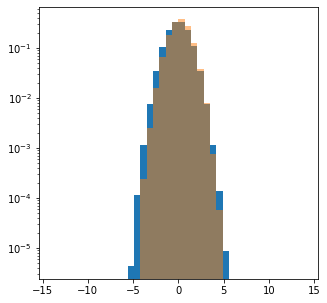

In [7]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins=40


for i in range(ndim) :
    if ndim > 1 :
        thisax = ax[i]
    else :
        thisax = ax
    thisax.hist( train_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True )
    thisax.hist( true_det_pts[:,i],bins=hbins, range=[hmin,hmax], density=True, alpha=0.5 )
    thisax.set_yscale('log')
    
plt.show

In [8]:
with open( "%s/omnifold-output-weights.npy" % input_dir,'rb') as f :
    main_sample_omnifold_weights = np.load(f)


In [9]:
main_sample_omnifold_weights = np.clip( main_sample_omnifold_weights, 1e-11, 1e11)

<function matplotlib.pyplot.show(close=None, block=None)>

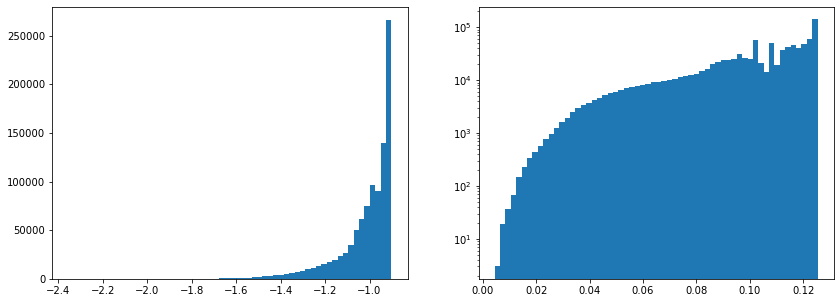

In [10]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(main_sample_omnifold_weights), bins=hbins)
ax[1].hist( main_sample_omnifold_weights, bins=hbins)
ax[1].set_yscale('log')
plt.show

In [11]:
true_rho

array([[0.]])

In [12]:
true_mu.shape

(1,)

In [13]:
true_cov = np.zeros( shape=(ndim,ndim) )

for i in range(ndim) :
    for j in range(ndim) :
        k = ndim - j - 1
        if i == j :
            true_cov[i][j] = true_sig[i]*true_sig[i]
        elif j > i :
            print(" %d, %d, %d" % (i,j,k))
            true_cov[i][j] = true_rho[i][k] * true_sig[i] * true_sig[j]

In [14]:
true_cov

array([[0.81]])

In [15]:
have_fits = False

if exists( "%s/fit-results.npy" % input_dir ) :
    have_fits = True
    print("\n\n Have fit results file.\n\n")



 Have fit results file.




In [16]:
if have_fits :
    
    with open( '%s/fit-results.npy' % input_dir, 'rb' ) as f :
        fit_results_mean_val = np.load(f, allow_pickle=True )
        fit_results_mean_err = np.load(f, allow_pickle=True )
        fit_results_cov_val = np.load(f, allow_pickle=True )
        fit_results_cov_err = np.load(f, allow_pickle=True )        
        

    ave_fit_err_mean = np.zeros( ndim )
    
    ave_fit_err_cov = np.zeros( shape=(ndim,ndim) )

    for fi in range(ndim) :
    
        ave_fit_err_mean[fi] = np.mean( fit_results_mean_err[fi,:])
        
        print( '%d : ave fit error, mean :  %8.4f' % (fi, ave_fit_err_mean[fi]))
        
    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            
            
            ave_fit_err_cov[fi1,fi2] = np.mean( fit_results_cov_err[fi1,fi2,:])
            
            print( 'fi1, fi2 : %d, %d    ave fit error, cov : %8.4f' % (fi1,fi2, ave_fit_err_cov[fi1,fi2]))
    

0 : ave fit error, mean :    0.0029
fi1, fi2 : 0, 0    ave fit error, cov :   0.0037


In [17]:
def calc_mean( weights, fi ) :
    
    mean = ( np.sum( weights * train_pts[:,fi]) ) / ( np.sum( weights ) )
    
    return mean

In [18]:
def calc_rms( weights, fi ) :
    
    x = calc_mean( weights, fi )
    xx = ( np.sum( weights * train_pts[:,fi] * train_pts[:,fi] ) ) / ( np.sum( weights ) )
    
    #print(" x = %f,  xx = %f" % (x, xx))
    
    return np.sqrt(xx - x*x)


In [19]:
def calc_cov( weights, fi1, fi2 ) :
    
    x1 = calc_mean( weights, fi1 )
    x2 = calc_mean( weights, fi2 )
    x1x2 = ( np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] ) ) / ( np.sum( weights ) )
    
    return np.sqrt( x1x2 - x1*x2 )
    

In [20]:
def calc_mean_cov( weights, fi1, fi2 ) :

    return_dict = {}
    
    wsum = np.sum( weights )
    
    wx1 = np.sum( weights * train_pts[:,fi1] )
    wx2 = np.sum( weights * train_pts[:,fi2] )
    wx1x2 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi2] )

    x1 = wx1 / wsum
    x2 = wx2 / wsum

    x1x2 = wx1x2 / wsum
    
    cov12 = x1x2 - x1*x2

    
    return_dict["mean_x1"] = x1
    return_dict["mean_x2"] = x2
    return_dict["cov_x1x2"] = cov12    
    
    if fi1 != fi2 :
        wx1x1 = np.sum( weights * train_pts[:,fi1] * train_pts[:,fi1] )
        wx2x2 = np.sum( weights * train_pts[:,fi2] * train_pts[:,fi2] )
        cov11 = wx1x1 / wsum - x1*x1
        cov22 = wx2x2 / wsum - x2*x2

        rms1 = np.sqrt(cov11)
        rms2 = np.sqrt(cov22)
        rho12 = cov12 / (rms1*rms2)     
    
        return_dict["rho12"] = rho12
        return_dict["rms1"] = rms1
        return_dict["rms2"] = rms2
    else :
        rms1 = np.sqrt(cov12)
        return_dict["rms1"] = rms1
        
    return return_dict


    

In [21]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d bootstrap samples.\n\n" % n_samples )



 Found 278 bootstrap samples.




In [22]:
%%time

all_mean = np.zeros( shape=(ndim,n_samples) )
all_rms = np.zeros( shape=(ndim,n_samples) )
all_cov = np.zeros( shape=(ndim,ndim,n_samples) )
all_rho = np.zeros( shape=(ndim,ndim,n_samples) )

all_weight_min = np.zeros( n_samples )
all_weight_max = np.zeros( n_samples )


si = 0

for fi in range(5000) :
    
    fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, fi)
    
    if exists(fname) :
        
        print('\n----- %s exists' % fname )
        
        with open(fname,'rb') as f :
            
            final_push_weights_scaled = np.load(f)
            print( len(final_push_weights_scaled))
            print( final_push_weights_scaled )
            print( true_pts[:,0])
            
            all_weight_min[si] = np.min( final_push_weights_scaled )
            all_weight_max[si] = np.max( final_push_weights_scaled )
            
            for fi1 in range(ndim) :
                for fi2 in range(fi1,ndim) :
                    mean_cov = calc_mean_cov( final_push_weights_scaled, fi1, fi2 )
                    all_cov[fi1,fi2,si] = mean_cov["cov_x1x2"]
                    all_cov[fi2,fi1,si] = mean_cov["cov_x1x2"]
                    if ( fi1 == fi2 ) :
                        print( "  %d %d  :  mean = %8.4f, RMS = %8.4f, cov = %8.4f" % 
                              (fi1, fi2, mean_cov["mean_x1"], mean_cov["rms1"], mean_cov["cov_x1x2"]))
                        all_mean[fi1,si] = mean_cov["mean_x1"]
                        all_rms[fi1,si] = mean_cov["rms1"]
                    else :
                        print( "  %d %d  :  rho = %8.4f,  cov = %8.4f" %
                              (fi1, fi2, mean_cov["rho12"], mean_cov["cov_x1x2"]) )
                        all_rho[fi1,fi2,si] = mean_cov["rho12"]
                        all_rho[fi2,fi1,si] = mean_cov["rho12"]
                        
        si = si + 1
        
            


----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-000.npy exists
1000000
[0.09829624 0.09935264 0.12471886 ... 0.0740127  0.10047238 0.11742211]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2014, RMS =   0.9032, cov =   0.8157

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-001.npy exists
1000000
[0.09606536 0.0979247  0.12404765 ... 0.07544144 0.10030828 0.11787981]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1984, RMS =   0.9036, cov =   0.8165

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-002.npy exists
1000000
[0.0986198  0.10069586 0.12327213 ... 0.07460131 0.10277691 0.12103396]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1984, RMS =   0.9019, cov =   0.8134

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-003.npy exists
1000000
[0.09784223 0.09907654 0.1223473  ... 0.07436843 0.10116119 0.1189015

  0 0  :  mean =   0.1915, RMS =   0.8994, cov =   0.8090

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-031.npy exists
1000000
[0.09710239 0.09847271 0.12228817 ... 0.07494201 0.10051415 0.1194366 ]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1962, RMS =   0.9086, cov =   0.8256

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-032.npy exists
1000000
[0.0974336  0.09881867 0.12199477 ... 0.07297171 0.10053912 0.11972858]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1965, RMS =   0.9036, cov =   0.8164

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-033.npy exists
1000000
[0.09816244 0.09939238 0.12142018 ... 0.07485484 0.10054033 0.11964209]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1983, RMS =   0.9055, cov =   0.8198

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-034.npy exists
1000000
[0.09825678


----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-067.npy exists
1000000
[0.09595461 0.09823915 0.12374409 ... 0.07519635 0.10103114 0.11962483]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1967, RMS =   0.9028, cov =   0.8151

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-068.npy exists
1000000
[0.09718827 0.09903636 0.12210541 ... 0.0737083  0.10035939 0.11920057]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1980, RMS =   0.9038, cov =   0.8168

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-069.npy exists
1000000
[0.0989375  0.09950872 0.12336076 ... 0.07402788 0.10024169 0.11911705]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2010, RMS =   0.9068, cov =   0.8223

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-070.npy exists
1000000
[0.09763575 0.09945764 0.12167538 ... 0.07367845 0.10150511 0.1172728

  0 0  :  mean =   0.1868, RMS =   0.9037, cov =   0.8167

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-100.npy exists
1000000
[0.09709868 0.09882087 0.12615936 ... 0.07326296 0.10041055 0.11962097]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2039, RMS =   0.9003, cov =   0.8105

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-101.npy exists
1000000
[0.09601037 0.09762911 0.12264207 ... 0.0752852  0.0998782  0.12066394]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1890, RMS =   0.9042, cov =   0.8176

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-102.npy exists
1000000
[0.09769307 0.09885542 0.12493529 ... 0.075771   0.10056147 0.12048865]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1967, RMS =   0.9029, cov =   0.8153

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-103.npy exists
1000000
[0.09722165

  0 0  :  mean =   0.2016, RMS =   0.9061, cov =   0.8211

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-135.npy exists
1000000
[0.09911774 0.10043209 0.12286811 ... 0.07476543 0.10155982 0.11870906]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1978, RMS =   0.9026, cov =   0.8147

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-136.npy exists
1000000
[0.09772983 0.09942566 0.12346249 ... 0.07462886 0.10055369 0.12163445]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1995, RMS =   0.9024, cov =   0.8143

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-137.npy exists
1000000
[0.09750276 0.09923676 0.12281098 ... 0.07385371 0.09959819 0.11881693]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2004, RMS =   0.9030, cov =   0.8155

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-138.npy exists
1000000
[0.09862421


----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-169.npy exists
1000000
[0.09921353 0.10077927 0.12188986 ... 0.07565148 0.1023496  0.11519496]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1909, RMS =   0.9072, cov =   0.8231

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-170.npy exists
1000000
[0.09856925 0.10013328 0.12323085 ... 0.07234043 0.10142402 0.11864628]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2009, RMS =   0.9060, cov =   0.8209

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-171.npy exists
1000000
[0.09735734 0.09893533 0.12339437 ... 0.07388936 0.10085257 0.11712938]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2065, RMS =   0.9058, cov =   0.8205

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-172.npy exists
1000000
[0.09664806 0.09762366 0.12459389 ... 0.07435591 0.09863165 0.1203704

  0 0  :  mean =   0.2056, RMS =   0.9024, cov =   0.8144

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-204.npy exists
1000000
[0.09841643 0.09938569 0.12498404 ... 0.07320642 0.10027235 0.1186995 ]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2072, RMS =   0.9054, cov =   0.8198

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-205.npy exists
1000000
[0.09767542 0.09954029 0.12336715 ... 0.07197107 0.10130165 0.12038483]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1997, RMS =   0.8974, cov =   0.8053

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-206.npy exists
1000000
[0.10038002 0.10123742 0.12396075 ... 0.07460079 0.10104332 0.11765029]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1987, RMS =   0.9059, cov =   0.8206

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-207.npy exists
1000000
[0.09789564

  0 0  :  mean =   0.2024, RMS =   0.9024, cov =   0.8143

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-242.npy exists
1000000
[0.09577786 0.0970316  0.12388307 ... 0.07438831 0.09864746 0.11885998]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2040, RMS =   0.9060, cov =   0.8208

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-243.npy exists
1000000
[0.09789773 0.09845129 0.12249691 ... 0.07464393 0.09893691 0.11857423]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.1923, RMS =   0.9009, cov =   0.8116

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-244.npy exists
1000000
[0.09722589 0.09929284 0.12497646 ... 0.07456396 0.10131278 0.11883835]
[ 0.79480285 -2.80673301  1.46663311 ... -0.20494562  1.21746036
  0.25424958]
  0 0  :  mean =   0.2003, RMS =   0.9016, cov =   0.8129

----- bootstrap-toy-study8a-1d-2a/bootstrap-weights-245.npy exists
1000000
[0.09717386

CPU times: user 1.37 s, sys: 298 ms, total: 1.67 s
Wall time: 1.59 s


In [23]:
all_mean

array([[0.2014092 , 0.19837764, 0.19836812, 0.19895226, 0.19630577,
        0.18943033, 0.2060373 , 0.20420603, 0.19912796, 0.19585896,
        0.20031942, 0.19758074, 0.1997549 , 0.19794551, 0.1976784 ,
        0.19602555, 0.20920306, 0.20119752, 0.19447753, 0.20085373,
        0.19670739, 0.20094104, 0.20233829, 0.19115121, 0.20817624,
        0.20061744, 0.19741758, 0.19792492, 0.19746924, 0.19635493,
        0.19148206, 0.19619676, 0.19647483, 0.19826781, 0.20462209,
        0.19786804, 0.19458946, 0.20274657, 0.20026639, 0.20116468,
        0.20110181, 0.19937154, 0.19672162, 0.20113274, 0.19515172,
        0.19546424, 0.19964911, 0.20452924, 0.19643027, 0.19843073,
        0.19697309, 0.1988539 , 0.1966836 , 0.1970543 , 0.20411295,
        0.19245566, 0.20227992, 0.19417005, 0.2061785 , 0.1976296 ,
        0.20028992, 0.19648717, 0.19936741, 0.20020078, 0.19441984,
        0.20277532, 0.20356185, 0.1966913 , 0.1979719 , 0.20102767,
        0.190575  , 0.20135307, 0.19992062, 0.19

<function matplotlib.pyplot.show(close=None, block=None)>

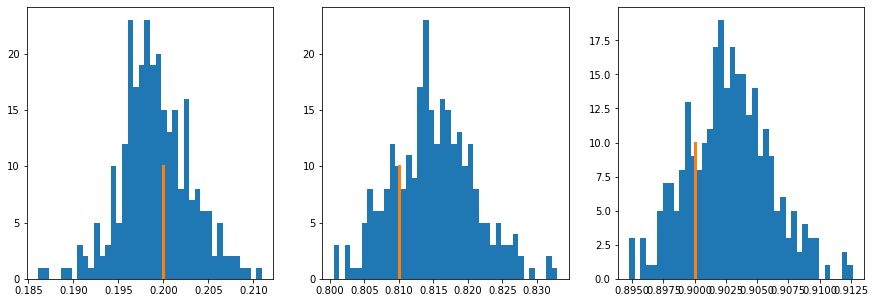

In [24]:
fig,ax = plt.subplots( ndim, 3, figsize=(3*5,ndim*5))

ymax = 10

for i in range(ndim) :
    
    if ndim > 1 :
        thisax = ax[i][0]
    else :
        thisax = ax[0]
    thisax.hist( all_mean[i], bins=40)
    thisax.plot( (true_mu[i], true_mu[i]), (0,ymax), linewidth=3 )
    
    if ndim > 1 :
        thisax = ax[i][1]
    else :
        thisax = ax[1]    
    thisax.hist( all_cov[i][i], bins=40)
    thisax.plot( (true_cov[i][i], true_cov[i][i]), (0,ymax), linewidth=3 )


    
    if ndim > 1 :
        thisax = ax[i][2]
    else :
        thisax = ax[2]    
    thisax.hist( all_rms[i], bins=40)
    thisax.plot( (true_sig[i], true_sig[i]), (0,ymax), linewidth=3 )    
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

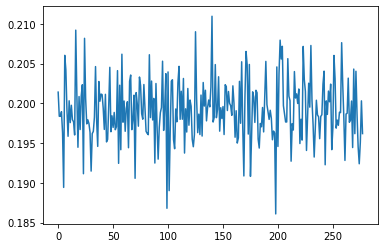

In [25]:
plt.plot(all_mean[0])
plt.show

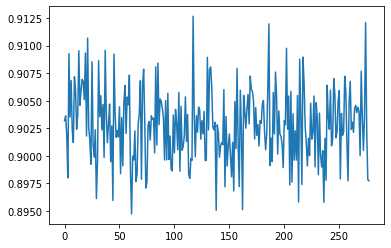

In [26]:
plt.plot(all_rms[0])

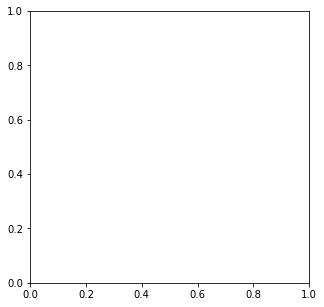

In [27]:
fig,ax = plt.subplots( ndim, ndim, figsize=(ndim*5,ndim*5))

ymax = 10

if ndim > 1 :

    for i in range(0,ndim-1) :

        for j in range(i+1,ndim) :

            k = ndim - j - 1

            ax[i][j].hist( all_rho[i,j], bins=40)

            ax[i][j].plot( (true_rho[i][k], true_rho[i][k]), (0, ymax), linewidth=3 )



    plt.show

In [28]:
print('\n')

ave_mean = np.zeros( ndim )
rms_mean = np.zeros( ndim )
rms_mean_err = np.zeros( ndim )

ave_cov = np.zeros( shape=(ndim,ndim) )
rms_cov = np.zeros( shape=(ndim,ndim) )
rms_cov_err = np.zeros( shape=(ndim,ndim) )


for fi in range(ndim) :
    
    ave_mean[fi] = np.mean( all_mean[fi] )
    ave_mean2 = np.mean( all_mean[fi]*all_mean[fi])
    rms_mean[fi] = np.sqrt( ave_mean2 - ave_mean[fi]*ave_mean[fi] )
    rms_mean_err[fi] = rms_mean[fi] / np.sqrt(2*n_samples)
    print("  feature %d  :  mean   ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" % 
          (fi, ave_mean[fi], true_mu[fi], rms_mean[fi], rms_mean_err[fi] ))
    
print('\n')

for fi in range(ndim) :
    
    ave_rms = np.mean( all_rms[fi] )
    ave_rms2 = np.mean( all_rms[fi]*all_rms[fi])
    rms_rms = np.sqrt( ave_rms2 - ave_rms*ave_rms )
    print("  feature %d  :  RMS    ave %8.4f  (true %8.4f), rms %8.4f" % (fi, ave_rms, true_sig[fi], rms_rms ))
    
print('\n')

for fi1 in range(0,ndim-1) :
    for fi2 in range(fi1+1, ndim) :
        k = ndim - fi2 - 1
        ave_rho = np.mean( all_rho[fi1,fi2])
        ave_rho2 = np.mean( all_rho[fi1,fi2]*all_rho[fi1,fi2] )
        rms_rho = np.sqrt( ave_rho2 - ave_rho*ave_rho )
        print("  feature %d, %d  :  rho    ave %8.4f  (true %8.4f), rms %8.4f" % ( fi1, fi2, ave_rho, true_rho[fi1][k], rms_rho ))
        
print("\n")

for fi1 in range(0,ndim) :
    for fi2 in range(fi1,ndim) :
        ave_cov[fi1,fi2] = np.mean( all_cov[fi1][fi2] )
        ave_cov2 = np.mean( all_cov[fi1][fi2]*all_cov[fi1][fi2] )
        rms_cov[fi1,fi2] = np.sqrt( ave_cov2 - ave_cov[fi1,fi2]*ave_cov[fi1,fi2] )
        rms_cov_err[fi1,fi2] = rms_cov[fi1,fi2]/np.sqrt(2*n_samples)
        print("  feature %d, %d  :  cov    ave %8.4f  (true %8.4f), rms %8.5f +/- %6.5f" %
              (fi1, fi2, ave_cov[fi1,fi2], true_cov[fi1,fi2], rms_cov[fi1,fi2], rms_cov_err[fi1,fi2] ) )

print("\n")



  feature 0  :  mean   ave   0.1991  (true   0.2000), rms  0.00388 +/- 0.00016


  feature 0  :  RMS    ave   0.9028  (true   0.9000), rms   0.0033




  feature 0, 0  :  cov    ave   0.8150  (true   0.8100), rms  0.00595 +/- 0.00025




## Save the simple direct calculation results for setting fit parameter ranges from RMS.

In [29]:
with open( '%s/simple-calc-results.npy' % input_dir, 'wb' ) as f :
    np.save( f, ave_mean )
    np.save( f, rms_mean )
    np.save( f, ave_cov )
    np.save( f, rms_cov )

In [30]:
all_mean.shape

(1, 278)

In [31]:
fit_results_mean_val.shape

(1, 50)

In [32]:
n_for_plot = 0

n_boot = len(all_mean[0])
n_fit  = len(fit_results_mean_val[0])

if n_boot > n_fit :
    n_for_plot = n_fit
else :
    n_for_plot = n_boot

print('  n_boot = %d,   n_fit = %d,   n_for_plot = %d' % (n_boot, n_fit, n_for_plot))



  n_boot = 278,   n_fit = 50,   n_for_plot = 50


   0 : x axis limits:  0.188, 0.210    y axis limits  0.188, 0.210


<function matplotlib.pyplot.show(close=None, block=None)>

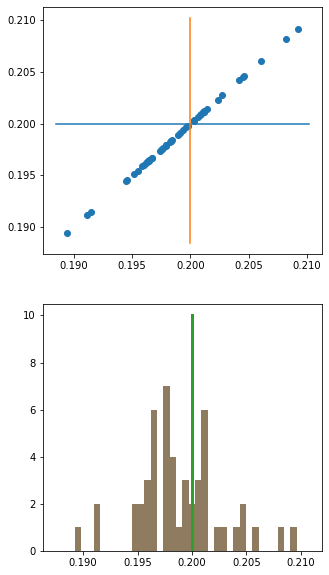

In [33]:
fig,ax = plt.subplots( 2, ndim, figsize=(5*ndim,5*2))

hbins=40
hmax = 10

for fi in range(ndim) :
    
    
    if ndim > 1 :
        thisax = ax[0][fi]
    else :
        thisax = ax[0]
        
    thisax.scatter( all_mean[fi,:n_for_plot], fit_results_mean_val[fi,:n_for_plot])
    xlow, xhigh = thisax.get_xlim()
    ylow, yhigh = thisax.get_ylim()
    print("  %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
              (fi, xlow, xhigh, ylow, yhigh))
    thisax.plot( (xlow, xhigh), (true_mu[fi], true_mu[fi]))
    thisax.plot( (true_mu[fi], true_mu[fi]), (ylow, yhigh))
    

    if ndim > 1 :
        thisax = ax[1][fi]
    else :
        thisax = ax[1]
    
    
    thisax.hist( fit_results_mean_val[fi,:n_for_plot], bins=hbins, 
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.hist( all_mean[fi,:n_for_plot], bins=hbins, alpha=0.5,
                   range=[ave_mean[fi]-3*rms_mean[fi], ave_mean[fi]+3*rms_mean[fi]])
    thisax.plot( (true_mu[fi],true_mu[fi]),(0,hmax), linewidth=3)
    

plt.show

In [34]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].scatter( all_cov[fi1,fi2,:], fit_results_cov_val[fi1,fi2,:])
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))
            ax[fi1][fi2].plot((xlow,xhigh),(true_cov[fi1][fi2], true_cov[fi1][fi2]))
            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(ylow,yhigh))

    plt.show

In [35]:
if ndim > 1 :

    fig,ax = plt.subplots( ndim, ndim, figsize=(5*ndim,5*ndim))

    hbins=40
    hmax=10

    for fi1 in range(ndim) :
        for fi2 in range(fi1,ndim) :
            ax[fi1][fi2].hist( fit_results_cov_val[fi1,fi2,:], bins=hbins, 
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            ax[fi1][fi2].hist( all_cov[fi1,fi2,:], bins=hbins, alpha=0.5,
                             range=[ave_cov[fi1,fi2]-3*rms_cov[fi1,fi2], ave_cov[fi1,fi2]+3*rms_cov[fi1][fi2]] )
            xlow, xhigh = ax[fi1][fi2].get_xlim()
            ylow, yhigh = ax[fi1][fi2].get_ylim()
            print("  %2d, %2d : x axis limits:  %.3f, %.3f    y axis limits  %.3f, %.3f" % 
                  (fi1, fi2, xlow, xhigh, ylow, yhigh))

            ax[fi1][fi2].plot((true_cov[fi1][fi2], true_cov[fi1][fi2]),(0,hmax), linewidth=3)

    plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

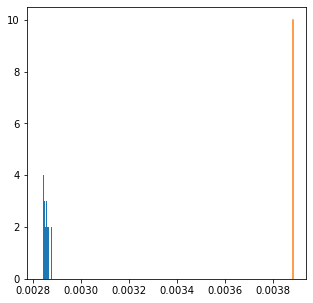

In [36]:
fig,ax = plt.subplots( 1, ndim, figsize=(5*ndim,5))

hbins = 40
hmax = 10

for fi in range(ndim) :
    if ndim > 1 :
        thisax = ax[fi]
    else :
        thisax = ax
        
    thisax.hist( fit_results_mean_err[fi,:], bins=hbins )
    thisax.plot( (rms_mean[fi], rms_mean[fi]), (0,hmax) )
    
    
plt.show

In [37]:
fit_results_mean_err

array([[0.00285579, 0.00285671, 0.00284563, 0.00283908, 0.00286581,
        0.0028553 , 0.00286619, 0.00285105, 0.00284789, 0.0028644 ,
        0.00286537, 0.00285012, 0.00285232, 0.00287783, 0.00285737,
        0.0028618 , 0.00286368, 0.00286222, 0.00285619, 0.00287742,
        0.00284495, 0.00288113, 0.00285053, 0.00284965, 0.00284613,
        0.00287969, 0.00284624, 0.00283966, 0.00285279, 0.00283127,
        0.00284624, 0.00286469, 0.00286151, 0.00286151, 0.00285299,
        0.00286007, 0.00284573, 0.00287524, 0.00285614, 0.00284887,
        0.00285616, 0.00285424, 0.00284465, 0.00285002, 0.00282893,
        0.00287088, 0.00285726, 0.00284905, 0.00285099, 0.0028517 ]])

<function matplotlib.pyplot.show(close=None, block=None)>

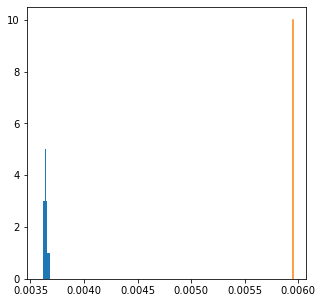

In [38]:
fig,ax = plt.subplots( 1, int((ndim*ndim+ndim)/2), figsize=(5*int((ndim*ndim+ndim)/2),5))

hbins = 40
hmax = 10

ai = 0

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        
        if ndim > 1 :
            thisax = ax[ai]
        else :
            thisax = ax

        thisax.hist( fit_results_cov_err[fi1,fi2,:], bins=hbins )
        thisax.plot( (rms_cov[fi1,fi2], rms_cov[fi1,fi2]), (0,hmax) )
        ai = ai + 1
    
plt.show

## Bootstrap error compared with average fit error

In [39]:
print('\n')

for fi in range(ndim) :
    
    print("  mean %d:  rms bootstraps %8.4f,  ave fit err %8.4f    ratio %6.2f |  val. %6.3f, true %6.3f, diff %6.3f"
         % (fi, rms_mean[fi], ave_fit_err_mean[fi], rms_mean[fi] / ave_fit_err_mean[fi], ave_mean[fi], true_mu[fi], ave_mean[fi]-true_mu[fi] ))
    
print('\n')

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        print("  cov%d%d:   rms bootstraps %8.4f,  ave fit err %8.4f    ratio %6.2f |  val. %6.3f, true %6.3f, diff %6.3f"
              % (fi1, fi2, rms_cov[fi1,fi2], ave_fit_err_cov[fi1,fi2], rms_cov[fi1,fi2]/ave_fit_err_cov[fi1,fi2], ave_cov[fi1,fi2], true_cov[fi1,fi2], ave_cov[fi1,fi2]-true_cov[fi1,fi2]) )
        

print('\n\n\n')

for fi in range(ndim) :
    
    print("  mean %d:  rms samples %8.4f +/- %6.4f,  ave fit err %8.4f    ratio %6.2f +/- %4.2f "
         % (fi, rms_mean[fi], rms_mean_err[fi],
            ave_fit_err_mean[fi], 
            rms_mean[fi] / ave_fit_err_mean[fi],
            rms_mean_err[fi] / ave_fit_err_mean[fi]))

for fi1 in range(ndim) :
    for fi2 in range(fi1,ndim) :
        print("  cov%d%d:   rms samples %8.4f +/- %6.4f,  ave fit err %8.4f    ratio %6.2f +/- %4.2f "
              % (fi1, fi2, rms_cov[fi1,fi2], rms_cov_err[fi1,fi2],
                 ave_fit_err_cov[fi1,fi2], 
                 rms_cov[fi1,fi2]/ave_fit_err_cov[fi1,fi2], rms_cov_err[fi1,fi2]/ave_fit_err_cov[fi1,fi2] ) )
        
print('\n')



  mean 0:  rms bootstraps   0.0039,  ave fit err   0.0029    ratio   1.36 |  val.  0.199, true  0.200, diff -0.001


  cov00:   rms bootstraps   0.0060,  ave fit err   0.0037    ratio   1.63 |  val.  0.815, true  0.810, diff  0.005




  mean 0:  rms samples   0.0039 +/- 0.0002,  ave fit err   0.0029    ratio   1.36 +/- 0.06 
  cov00:   rms samples   0.0060 +/- 0.0003,  ave fit err   0.0037    ratio   1.63 +/- 0.07 




## Look for outliers in feature coords and weights

In [40]:
for fi in range( ndim ) :
    
    print( "  feature %2d :  min %12f   max %12f " % ( fi, np.min(train_pts[:,fi]), np.max(train_pts[:,fi])) )

  feature  0 :  min    -4.991820   max     4.777219 


In [41]:
for si in range( n_samples ) :
    
    max_delta_mean = 0
    for fi in range(ndim) :
        delta = fit_results_mean_val[fi,si] - all_mean[fi,si] 
        if np.abs(delta) > max_delta_mean :
            max_delta_mean = delta
        
    print("  %3d : weight range  %12g  to %12f ,   max delta mean  %12f"
         % (si, all_weight_min[si], all_weight_max[si], max_delta_mean ))

    0 : weight range    0.00392125  to     0.124728 ,   max delta mean      0.000001
    1 : weight range    0.00317352  to     0.124174 ,   max delta mean     -0.000017
    2 : weight range     0.0034477  to     0.124908 ,   max delta mean      0.000000
    3 : weight range    0.00303221  to     0.123025 ,   max delta mean      0.000000
    4 : weight range    0.00401046  to     0.124911 ,   max delta mean      0.000004
    5 : weight range    0.00541333  to     0.121702 ,   max delta mean      0.000006
    6 : weight range    0.00389484  to     0.124609 ,   max delta mean      0.000002
    7 : weight range    0.00329391  to     0.125128 ,   max delta mean     -0.000001
    8 : weight range    0.00316984  to     0.123200 ,   max delta mean      0.000001
    9 : weight range    0.00463818  to     0.123179 ,   max delta mean      0.000004
   10 : weight range    0.00528244  to     0.123387 ,   max delta mean      0.000000
   11 : weight range    0.00500286  to     0.124656 ,   max delta

IndexError: index 50 is out of bounds for axis 1 with size 50

## Look deeper into bootstrap with an outlier

In [ ]:
si = 35

fname = '%s/bootstrap-weights-%03d.npy' % (input_dir, si)
            
with open(fname,'rb') as f :
            
    final_push_weights_scaled = np.load(f)

In [ ]:
fig,ax = plt.subplots( 1, 2, figsize=(2*7,5))

hbins = 60
ax[0].hist( np.log10(final_push_weights_scaled), bins=hbins)
ax[1].hist( final_push_weights_scaled, bins=hbins)
ax[1].set_yscale('log')

plt.show

In [ ]:
selection_mask = final_push_weights_scaled < 100
train_pts_sel = train_pts[ selection_mask ]
weights_sel = final_push_weights_scaled[ selection_mask ]

print(" number of events before selection  %d" % len(train_pts))
print(" number of events passing selection %d" % len(train_pts_sel))
print(" max weight before selection : %f" % np.max(final_push_weights_scaled))
print(" max weight passing selection: %f" % np.max(weights_sel))

In [ ]:
for fi in range( ndim ) :
    
    fit_mean = fit_results_mean_val[fi,si]
    mean_all_evts = all_mean[fi,si]
    mean_sel = ( np.sum( weights_sel * train_pts_sel[:,fi]) ) / ( np.sum( weights_sel ) )
    mean_diff = mean_sel - mean_all_evts
    print(" %2d :  fit mean  %10f   mean all  %10f   selected  %10f   diff %10f  fit diff %10f" % 
          ( fi, fit_mean, mean_all_evts, mean_sel, mean_diff, (mean_sel-fit_mean) ))

## Look at outlier point

In [ ]:
train_pts_antisel = train_pts[ final_push_weights_scaled > 100 ]
train_pts_antisel.shape

In [ ]:
for fi in range( ndim ) :
    
    sigma = np.sqrt(ave_cov[fi,fi])
    
    print(" %2d :  val %10f   mean %10f   sigma %10f  diff/sigma %10f" %
          (fi, train_pts_antisel[0,fi], ave_mean[fi], sigma, (train_pts_antisel[0,fi]-ave_mean[fi])/sigma )
         )

In [ ]:
true_sig

## Calculate the true weights and compare with unfolding weights